# 1. Libraries

### A. Install required Packages

In [ ]:
# !pip install matplotlib
# !pip install seaborn
# !pip install cmdstanpy
# !pip install arviz
# !pip install geopandas
# !pip install mapclassify
# !pip install cmdstanpy

# import cmdstanpy
# cmdstanpy.install_cmdstan()

: 

### B. Import Packages

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from cmdstanpy import CmdStanModel, cmdstan_path
import arviz as az
from pathlib import Path

from loadData import load_data
from imputeMissing import impute_value

import logging
logging.getLogger("cmdstanpy").setLevel(logging.INFO)

# 2. Datasets

### A. Import the datasets

In [10]:
## Get file paths
csv_file = './Data/rstb20160308supp1.csv'

## Shapefile paths for districts
lib_1 = './gadm41_LBR_shp/gadm41_LBR_2.shp'
gin_1 = './gadm41_GIN_shp/gadm41_GIN_2.shp'
sle_1 = './gadm41_SLE_shp/gadm41_SLE_2.shp'

## shapefile paths for country
lib_0 = './gadm41_LBR_shp/gadm41_LBR_0.shp'
gin_0 = './gadm41_GIN_shp/gadm41_GIN_0.shp'
sle_0 = './gadm41_SLE_shp/gadm41_SLE_0.shp'

In [11]:
## Load data
ebola = load_data(csv_file) ## Ebola data

## District level shapefile
lib = load_data(lib_1, shapefile=True) ## Liberia
gin = load_data(gin_1, shapefile=True) ## Guinea
sle = load_data(sle_1, shapefile=True) ## Sierra Leone

## Country level shapefile
country_lib = load_data(lib_0, shapefile=True) ## Liberia
country_gin = load_data(gin_0, shapefile=True) ## guinea
country_sle = load_data(sle_0, shapefile=True) ## Sierra Leone

## concatenate the shape files
districts = pd.concat([lib, gin, sle], ignore_index=True)
country = pd.concat([country_lib, country_gin, country_sle], ignore_index=True)

Loading data from ./Data/rstb20160308supp1.csv...Please wait!
Done loading data from ./Data/rstb20160308supp1.csv!!!
 There are 33338 rows of observations.
 There are 16 columns
Loading data from ./gadm41_LBR_shp/gadm41_LBR_2.shp...Please wait!
Done loading data from ./gadm41_LBR_shp/gadm41_LBR_2.shp!!!
 There are 66 rows of observations.
 There are 14 columns
Loading data from ./gadm41_GIN_shp/gadm41_GIN_2.shp...Please wait!
Done loading data from ./gadm41_GIN_shp/gadm41_GIN_2.shp!!!
 There are 34 rows of observations.
 There are 14 columns
Loading data from ./gadm41_SLE_shp/gadm41_SLE_2.shp...Please wait!
Done loading data from ./gadm41_SLE_shp/gadm41_SLE_2.shp!!!
 There are 14 rows of observations.
 There are 14 columns
Loading data from ./gadm41_LBR_shp/gadm41_LBR_0.shp...Please wait!
Done loading data from ./gadm41_LBR_shp/gadm41_LBR_0.shp!!!
 There are 1 rows of observations.
 There are 3 columns
Loading data from ./gadm41_GIN_shp/gadm41_GIN_0.shp...Please wait!
Done loading data

# 3. Exploratory Data Analysis

## A. View the data by loading few values of each dataset

In [12]:
ebola.head()

,Country,EpiCaseDef,FinalStatus,DateOnset,DateOnsetInferred,DateReport,DateOutcomeComp,DateHospitalCurrentAdmit,Age,CL_DistrictRes,HospitalizedEver,TreatmentCendreType,TreatmentCentre,delay.onset.hospitalisation,QuarterOnsetInferred,retrospective
0,Guinea,confirmed,Dead,2015-02-06,2015-02-06,2015-02-06,2015-02-06,NaN,45.0,FORECARIAH,No,Not Hospitalised,NaN,NaN,Jan - Mar 2015,True
1,Guinea,confirmed,Dead,2015-03-02,2015-03-02,2015-03-07,2015-03-07,NaN,40.0,CONAKRY,No,Not Hospitalised,NaN,NaN,Jan - Mar 2015,True
2,Guinea,confirmed,Dead,2015-03-15,2015-03-15,2015-03-17,2015-03-18,2015-03-18,0.0,FORECARIAH,Yes,ETU,Conakry 2,3.0,Jan - Mar 2015,False
3,Guinea,confirmed,Dead,2014-06-06,2014-06-06,2014-06-09,2014-06-16,2014-06-09,30.0,GUECKEDOU,Yes,ETU,Gueckedou 1,3.0,Apr - Jun 2014,False
4,Guinea,probable,Dead,2014-02-27,2014-02-27,2014-02-27,2014-03-03,NaN,46.0,GUECKEDOU,Yes,Unknown TC Type,NaN,NaN,Jan - Mar 2014,False


In [13]:
districts.head()

,GID_2,GID_0,COUNTRY,GID_1,NAME_1,NL_NAME_1,NAME_2,VARNAME_2,NL_NAME_2,TYPE_2,ENGTYPE_2,CC_2,HASC_2,geometry
0,LBR.1.1_1,LBR,Liberia,LBR.1_1,Bomi,NA,Klay,NA,NA,District,District,02,NA,"POLYGON ((-10.65347 6.67006, -10.65153 6.66552..."
1,LBR.1.2_1,LBR,Liberia,LBR.1_1,Bomi,NA,Mecca,NA,NA,District,District,04,NA,"POLYGON ((-10.65347 6.67006, -10.65926 6.69014..."
2,LBR.2.1_1,LBR,Liberia,LBR.2_1,Bong,NA,Fuamah,NA,NA,District,District,02,NA,"POLYGON ((-10.20627 6.80659, -10.20628 6.80142..."
3,LBR.2.2_1,LBR,Liberia,LBR.2_1,Bong,NA,Jorquelleh,NA,NA,District,District,04,NA,"POLYGON ((-9.35354 6.96628, -9.35357 6.94881, ..."
4,LBR.2.3_1,LBR,Liberia,LBR.2_1,Bong,NA,Kokoyah,NA,NA,District,District,06,NA,"POLYGON ((-9.49983 6.64371, -9.47651 6.64245, ..."


In [14]:
country.head()

,GID_0,COUNTRY,geometry
0,LBR,Liberia,"MULTIPOLYGON (((-7.56396 4.68852, -7.56542 4.6..."
1,GIN,Guinea,"MULTIPOLYGON (((-8.70727 7.63474, -8.70433 7.6..."
2,SLE,Sierra Leone,"MULTIPOLYGON (((-11.61903 6.99514, -11.61903 6..."


----------------------------------------------------------------



----------------------------------------------------------------

## B. Information about the Datasets

In [15]:
ebola.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33338 entries, 0 to 33337
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Country                      33338 non-null  object 
 1   EpiCaseDef                   33338 non-null  object 
 2   FinalStatus                  18644 non-null  object 
 3   DateOnset                    27143 non-null  object 
 4   DateOnsetInferred            33318 non-null  object 
 5   DateReport                   27346 non-null  object 
 6   DateOutcomeComp              12283 non-null  object 
 7   DateHospitalCurrentAdmit     10286 non-null  object 
 8   Age                          31800 non-null  float64
 9   CL_DistrictRes               32354 non-null  object 
 10  HospitalizedEver             25210 non-null  object 
 11  TreatmentCendreType          33338 non-null  object 
 12  TreatmentCentre              10736 non-null  object 
 13  delay.onset.hosp

----------------------------------------------------------------

**Missing Observations:**

We can see that most of the variables from the Ebola data have missing observations. There are **33338** total observations but only 4 variables (*country, EpiCaseDef, TreatmentCendreType, retrospective*) are complete. Some important variables such as *FinalStatus, DateOnset, DateReport, CL_DistrictRes, and HospitalizedEver* have missing observations with *FinalStatus* variable missing almost half of the observations.

**Data Types:**

All the date variables are presented as *object* datatypes. This can affect the analysis we would want to run, hence it is best we convert all the dates to the *datetime* data type.

----------------------------------------------------------------

In [16]:
districts.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   GID_2      114 non-null    object  
 1   GID_0      114 non-null    object  
 2   COUNTRY    114 non-null    object  
 3   GID_1      114 non-null    object  
 4   NAME_1     114 non-null    object  
 5   NL_NAME_1  114 non-null    object  
 6   NAME_2     114 non-null    object  
 7   VARNAME_2  114 non-null    object  
 8   NL_NAME_2  114 non-null    object  
 9   TYPE_2     114 non-null    object  
 10  ENGTYPE_2  114 non-null    object  
 11  CC_2       114 non-null    object  
 12  HASC_2     114 non-null    object  
 13  geometry   114 non-null    geometry
dtypes: geometry(1), object(13)
memory usage: 12.6+ KB


-------------------------------------------------------------------

There are a total of **114** rows of district observations with no missing values in the variables that are of interest to this analysis. These variables are *COUNTRY, NAME_1, NAME_2, geometry*. 

-------------------------------------------------------------------

In [17]:
country.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   GID_0     3 non-null      object  
 1   COUNTRY   3 non-null      object  
 2   geometry  3 non-null      geometry
dtypes: geometry(1), object(2)
memory usage: 204.0+ bytes


-------------------------------------------------------------------

There are a total of **3** rows of country observations with no missing values in the variables that are of interest to this analysis. These variables are *COUNTRY, geometry*.

-------------------------------------------------------------------

In [18]:
ebola.Country.value_counts()

Country
Sierra Leone    21451
Liberia          8130
Guinea           3757
Name: count, dtype: int64

In [19]:
ebola['EpiCaseDef'].value_counts()

EpiCaseDef
confirmed    16444
suspected    12984
probable      3910
Name: count, dtype: int64

In [20]:
ebola['FinalStatus'].value_counts()

FinalStatus
Dead     14533
Alive     4111
Name: count, dtype: int64

## C. Data Cleaning

### 1. Data Type Conversion

The Date variables are treated as a Text data. I will convert them to date format to enable me use them for the analysis.

In [22]:
date = ['DateOnset', 'DateOnsetInferred', 'DateReport', 'DateOutcomeComp', 'DateHospitalCurrentAdmit']

ebola[date] = ebola[date].apply(pd.to_datetime, format='%Y-%m-%d')

In [23]:
## check the datatypes
ebola.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33338 entries, 0 to 33337
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Country                      33338 non-null  object        
 1   EpiCaseDef                   33338 non-null  object        
 2   FinalStatus                  18644 non-null  object        
 3   DateOnset                    27143 non-null  datetime64[ns]
 4   DateOnsetInferred            33318 non-null  datetime64[ns]
 5   DateReport                   27346 non-null  datetime64[ns]
 6   DateOutcomeComp              12283 non-null  datetime64[ns]
 7   DateHospitalCurrentAdmit     10286 non-null  datetime64[ns]
 8   Age                          31800 non-null  float64       
 9   CL_DistrictRes               32354 non-null  object        
 10  HospitalizedEver             25210 non-null  object        
 11  TreatmentCendreType          33338 non-nu

### 2. Removing Unwanted Variables

The shapefile datasets contains data for all countries in West Africa so I will filter for only **Sierra Leone, Liberia,** and **Guinea** since they are the only countries in the Ebola dataset.

In [24]:
## define a function to filter the dataset
def filter_column(
        df, 
        column: list,
        main_countries: list = None #['Guinea', 'Liberia', 'Sierra Leone']
    ):
        """
        Filter the dataframe based on the value in the specified column.

        Parameters:
            df : The dataframe to filter.
            column : The columns to filter by.
            main_countries : The countries of interest with default countries as Guinea, Liberia, and Sierra Leone.

        Returns:
            The filtered dataframe.
        """
        ## select the columns of interest
        df_filter = df[column]

        ## rename admin0Name to Country
        if 'admin0Name' in df_filter.columns:
            df_filter = df_filter.rename(columns={'admin0Name': 'Country'})

        ## select the countries of interest
        if main_countries is not None:
            if 'Country' in df_filter.columns:
                df_filter = df_filter[df_filter['Country'].isin(main_countries)]
        print(f'Data filtering done!')
        return df_filter


In [25]:
## Filter the dataset
districts_filter = filter_column(districts,['COUNTRY','NAME_1', 'NAME_2', 'geometry'])

country_filter = filter_column(country, ['COUNTRY', 'geometry'])

Data filtering done!
Data filtering done!


In [26]:
districts_filter.COUNTRY.unique()

array(['Liberia', 'Guinea', 'Sierra Leone'], dtype=object)

In [27]:
country_filter.head()

,COUNTRY,geometry
0,Liberia,"MULTIPOLYGON (((-7.56396 4.68852, -7.56542 4.6..."
1,Guinea,"MULTIPOLYGON (((-8.70727 7.63474, -8.70433 7.6..."
2,Sierra Leone,"MULTIPOLYGON (((-11.61903 6.99514, -11.61903 6..."


### 3. Comparing the CL_District column and the NAME_1 & NAME_2 of the shapefile columns

In [28]:
## Convert the CL_District values to Proper
ebola.CL_DistrictRes = ebola.CL_DistrictRes.str.title()

In [29]:
print(f"Ebola dataset for Guinea Districts:\n {ebola[(ebola['Country']=='Guinea')]['CL_DistrictRes'].unique()}")
print(f"has lenght: {len(ebola[(ebola['Country']=='Guinea')]['CL_DistrictRes'].unique())}")
print('\n')
print(f"Guinea Districts from shapefile (NAME_1):\n {districts_filter[(districts_filter['COUNTRY']=='Guinea')]['NAME_1'].unique()}")
print(f"has lenght: {len(districts_filter[(districts_filter['COUNTRY']=='Guinea')]['NAME_1'].unique())}")
print('\n')
print(f"Guinea Districts from shapefile (NAME_2):\n {districts_filter[(districts_filter['COUNTRY']=='Guinea')]['NAME_2'].unique()}")
print(f"has lenght: {len(districts_filter[(districts_filter['COUNTRY']=='Guinea')]['NAME_2'].unique())}")

Ebola dataset for Guinea Districts:
 ['Forecariah' 'Conakry' 'Gueckedou' 'Boke' "N'Zerekore" 'Macenta'
 'Kerouane' 'Faranah' 'Kindia' 'Coyah' 'Lola' 'Pita' 'Kissidougo' 'Beyla'
 'Dubreka' 'Boffa' 'Kankan' 'Siguiri' 'Yomou' 'Telimele' 'Dalaba' 'Dabola'
 'Kouroussa' 'Fria' 'Mali' 'Dinguiraye' 'Tougue' nan]
has lenght: 28


Guinea Districts from shapefile (NAME_1):
 ['Boké' 'Conakry' 'Faranah' 'Kankan' 'Kindia' 'Labé' 'Mamou' 'Nzérékoré']
has lenght: 8


Guinea Districts from shapefile (NAME_2):
 ['Boffa' 'Boké' 'Fria' 'Gaoual' 'Koundara' 'Conakry' 'Dabola' 'Dinguiraye'
 'Faranah' 'Kissidougou' 'Kankan' 'Kérouané' 'Kouroussa' 'Mandiana'
 'Siguiri' 'Coyah' 'Dubréka' 'Forécariah' 'Kindia' 'Télimélé' 'Koubia'
 'Labé' 'Lélouma' 'Mali' 'Tougué' 'Dalaba' 'Mamou' 'Pita' 'Beyla'
 'Guéckédou' 'Lola' 'Macenta' 'Nzérékoré' 'Yamou']
has lenght: 34


--------------------------------------------------

Most of District level(NAME_2) values are similar to the CL_District of the Ebola data for Guinea. We can see that some of the have different language spellings but are the same districts. I will correct them by renaming the values from the CL_District to match the shape file values.

These values are similar and will be renamed:

**'Boke':'Boké, 'Kissidougo':'Kissidougou', 'Kerouane':'Kérouané', 'Dubreka':'Dubréka', 'Forecariah':'Forécariah', 'Telimele':'Télimélé', 'Tougue':'Tougué', 'Gueckedou':'Guéckédou' "N'Zerekore":'Nzérékoré'**

These values are not found in the Ebola data district:

**'Gaoual', 'Koundara', 'Mandiana','Koubia','Labé', 'Lélouma','Mamou'**

There is a *nan* value which not consistent with the values in the data hence will be removed.

--------------------------------------------------

In [30]:
print(f"Ebola dataset - Sierra Leone Districts:\n {ebola[(ebola['Country']=='Sierra Leone')]['CL_DistrictRes'].unique()}")
print(f"has lenght: {len(ebola[(ebola['Country']=='Sierra Leone')]['CL_DistrictRes'].unique())}")
print('\n')
print(f"Districts for Sierra Leone from shapefile (NAME_1):\n {districts_filter[(districts_filter['COUNTRY']=='Sierra Leone')]['NAME_1'].unique()}")
print(f"has lenght: {len(districts_filter[(districts_filter['COUNTRY']=='Sierra Leone')]['NAME_1'].unique())}")
print('\n')
print(f"Districts for Sierra Leone from shapefile (NAME_2):\n {districts_filter[(districts_filter['COUNTRY']=='Sierra Leone')]['NAME_2'].unique()}")
print(f"has lenght: {len(districts_filter[(districts_filter['COUNTRY']=='Sierra Leone')]['NAME_2'].unique())}")

Ebola dataset - Sierra Leone Districts:
 ['Bo' 'Kono' 'Tonkolili' nan 'Moyamba' 'Western' 'Pujehun' 'Port Loko'
 'Bombali' 'Kenema' 'Kailahun' 'Kambia' 'Koinadugu' 'Bonthe']
has lenght: 14


Districts for Sierra Leone from shapefile (NAME_1):
 ['Eastern' 'Northern' 'Southern' 'Western']
has lenght: 4


Districts for Sierra Leone from shapefile (NAME_2):
 ['Kailahun' 'Kenema' 'Kono' 'Bombali' 'Kambia' 'Koinadugu' 'Port Loko'
 'Tonkolili' 'Bo' 'Bonthe' 'Moyamba' 'Pujehun' 'Western Rural'
 'Western Urban']
has lenght: 14


-----------------------------------------------------------------

We can see that the **NAME_2** values from the shape file are similar to the District values of the Sierra Leone Ebola data. Hence, we will use the **NAME_2** values for further analysis.

There is a **Western Rural** and **Western Urban** in shapefile but it's only **Western** that is present in Ebola data, hence I will rename the **Western Rural** and **Western Urban** to **Western**.

There is a *nan* value which not consistent with the values in the data hence will be removed.

-----------------------------------------------------------------

In [31]:
print(f"Ebola dataset for Liberia Districts:\n {ebola[(ebola['Country']=='Liberia')]['CL_DistrictRes'].unique()}")
print(f"has lenght: {len(ebola[(ebola['Country']=='Liberia')]['CL_DistrictRes'].unique())}")
print('\n')
print(f"Districts for Liberia from shapefile (NAME_1):\n {districts_filter[(districts_filter['COUNTRY']=='Liberia')]['NAME_1'].unique()}")
print(f"has lenght: {len(districts_filter[(districts_filter['COUNTRY']=='Liberia')]['NAME_1'].unique())}")
print('\n')
print(f"Districts for Liberia from shapefile (NAME_2):\n {districts_filter[(districts_filter['COUNTRY']=='Liberia')]['NAME_2'].unique()}")
print(f"has lenght: {len(districts_filter[(districts_filter['COUNTRY']=='Liberia')]['NAME_2'].unique())}")

Ebola dataset for Liberia Districts:
 ['Montserrado' nan 'Margibi' 'Nimba' 'Grand Bassa' 'Sinoe' 'Bomi' 'Bong'
 'Lofa' 'Grand Cape Mount' 'Rivercess' 'Gbarpolu' 'Grand Kru'
 'Grand Gedeh' 'River Gee' 'Maryland']
has lenght: 16


Districts for Liberia from shapefile (NAME_1):
 ['Bomi' 'Bong' 'Gbapolu' 'Grand Bassa' 'Grand Cape Mount' 'Grand Gedeh'
 'Grand Kru' 'Lofa' 'Margibi' 'Maryland' 'Montserrado' 'Nimba' 'River Gee'
 'Rivercess' 'Sinoe']
has lenght: 15


Districts for Liberia from shapefile (NAME_2):
 ['Klay' 'Mecca' 'Fuamah' 'Jorquelleh' 'Kokoyah' 'Panta-Kpa' 'Salala'
 'Sanayea' 'Suakoko' 'Zota' 'Belleh' 'Bokomu' 'Bopolu' 'Gbarma' 'Kongba'
 'District # 1' 'District # 2' 'District # 3' 'District # 4' 'Owensgrove'
 'Stjohnriver' 'Commnwealth' 'Garwula' 'Golakonneh' 'Porkpa' 'Tewor'
 'Gbarzon' 'Konobo' 'Tchien' 'Buah' 'Lower Kru Coast' 'Sasstown 180606'
 'Upperkrucoast' 'Foya' 'Kolahun' 'Salayea' 'Voinjama' 'Zorzor'
 'Firestone' 'Gibi' 'Kakata' 'Mambah-Kaba' 'Barrobo' 'Pleebo/Sodeken

------------------------------------------------------

The District column (NAME_1) from the shapefile looks similar to the CL_District in the Ebola data for Liberia. While the **NAME_2** column is far from being similar to the Ebola CL_District column, we will replace the values in the **NAME_2** column of the shape file with the **NAME_1** values for Liberia.

There is a *nan* value which not consistent with the values in the data hence will be removed.

------------------------------------------------------

#### Cleaning Inconsistent names

In [32]:
## renaming values
val = {
        'Boke':'Boké', 'Kissidougo':'Kissidougou', 'Kerouane':'Kérouané', 'Dubreka':'Dubréka', 
       'Forecariah':'Forécariah', 'Telimele':'Télimélé', 'Tougue':'Tougué', 
       'Gueckedou':'Guéckédou', "N'Zerekore":'Nzérékoré'
       }
ebola['CL_DistrictRes'] = ebola['CL_DistrictRes'].replace(val)


## Renaming the shapefile values
districts_filter['NAME_2'] = districts_filter['NAME_2'].replace({'Western Rural': 'Western', 'Western Urban': 'Western'})


/media/brasammy/5B6DAD9B6A1F7E40/Projects/Thesis/Main/thesis/.myenv/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


#### Replace NAME_2 values of the shapefile for Liberia with NAME_1 values

In [33]:
districts_filter.loc[districts_filter['COUNTRY'] == 'Liberia', 'NAME_2'] = districts_filter.loc[districts_filter['COUNTRY'] == 'Liberia', 'NAME_1']

In [34]:
print(f"Districts for Liberia from shapefile (NAME_2):\n {districts_filter[(districts_filter['COUNTRY']=='Liberia')]['NAME_2'].unique()}")
print(f"has lenght: {len(districts_filter[(districts_filter['COUNTRY']=='Liberia')]['NAME_2'].unique())}")

Districts for Liberia from shapefile (NAME_2):
 ['Bomi' 'Bong' 'Gbapolu' 'Grand Bassa' 'Grand Cape Mount' 'Grand Gedeh'
 'Grand Kru' 'Lofa' 'Margibi' 'Maryland' 'Montserrado' 'Nimba' 'River Gee'
 'Rivercess' 'Sinoe']
has lenght: 15


#### Remove the NaN values from the CL_District column

In [35]:
## remove the nan from the ebola data
# ebola.head()

In [36]:
# ebola_v1 = ebola.dropna(subset=['CL_DistrictRes'])

In [37]:
# print(f"Number of rows in the ebola dataset: {ebola.shape[0]}")
# print(f"Number of rows in the ebola dataset after removing nan: {ebola_v1.shape[0]}")
# ebola_v1[ebola_v1['CL_DistrictRes'].isna()]

------------------------------------------------------

There were about 984 rows of observations that did not have District names recorded. Out of the **984**, **716** of them were having no records for the **FinalStatus** variable. These values again has missing value for most of the variables.

After removing, the Ebola data has **32354** observations.

-------------------------------------------------------

In [38]:
# ebola.info()

In [39]:
# ebola_v1.info()

### 4. Impute missing DateOnset

#### A. Check for missing values

In [40]:
## Check for missing values
print("Missing DateOnset:", ebola["DateOnset"].isna().sum())
print("Missing DateOnsetInferred:", ebola["DateOnsetInferred"].isna().sum())
print("Missing DateReport:", ebola["DateReport"].isna().sum())

Missing DateOnset: 6195
Missing DateOnsetInferred: 20
Missing DateReport: 5992


#### B. Calculate Reporting delays

This will help us impute the missing values correctly for each Country and probably for each District.

We will create a new column **Reporting Delay** and subtract **DateOnset** from the **DateReport** to give us the delay.

In [41]:
# Calculate reporting delay where both dates are available
ebola["ReportingDelay"] = (ebola["DateReport"] - ebola["DateOnset"]).dt.days
delay_data = ebola.dropna(subset=["ReportingDelay"])

# Calculate median reporting delay by district
median_delay_by_district = delay_data.groupby(["Country", "CL_DistrictRes"])["ReportingDelay"].median()
median_delay_country = delay_data.groupby("Country")["ReportingDelay"].median()

# Calculate overall median delay as a fallback
overall_median_delay = delay_data["ReportingDelay"].median()

In [42]:
print("Median Reporting Delay (days) by Country and District:\n")
print(median_delay_by_district.head(10))
print("\nOverall Median Reporting Delay (days):", overall_median_delay)

Median Reporting Delay (days) by Country and District:

Country  CL_DistrictRes
Guinea   Beyla             5.0
         Boffa             5.0
         Boké              4.0
         Conakry           5.0
         Coyah             5.0
         Dabola            7.0
         Dalaba            5.0
         Dinguiraye        7.0
         Dubréka           5.0
         Faranah           5.0
Name: ReportingDelay, dtype: float64

Overall Median Reporting Delay (days): 4.0


#### C. Impute the missing Dates for **DateOnset**

The **DateReport** is the date when the case was reported, which occurs after the onset of symptoms ( which is the **DateOnset**). In the 2014–2016 Ebola outbreak, reporting delays were common, often ranging from a few days to two weeks, depending on the country and phase of the outbreak.

We can impute **DateOnset** by subtracting an estimated reporting delay from DateReport. The delay will be estimated using cases where both DateOnset and DateReport are available.

In [43]:
ebola["OnsetDate"] = ebola.apply(
    lambda row: impute_value(row, median_delay_by_district, overall_median_delay, ebola),
    axis=1
)

Value already exist...!
Value already exist...!
Value already exist...!
Value already exist...!
Value already exist...!
Value already exist...!
Value already exist...!
Value already exist...!
Value already exist...!
Value already exist...!
Value already exist...!
Value already exist...!
Value already exist...!
Value already exist...!
Value already exist...!
Value already exist...!
Value already exist...!
Value already exist...!
Value already exist...!
Value already exist...!
Value already exist...!
Value already exist...!
Value already exist...!
Value already exist...!
Value already exist...!
Value already exist...!
Value already exist...!
Value already exist...!
Value already exist...!
Value already exist...!
Value already exist...!
Value already exist...!
Value already exist...!
Value already exist...!
Value already exist...!
Value already exist...!
Value already exist...!
Value already exist...!
Value already exist...!
Value already exist...!
Value already exist...!
Value already ex

#### D. Let's create infection cases, death cases and survival cases

In [44]:
ebola_confirmed = ebola[ebola["EpiCaseDef"] == "confirmed"]

# get cases by day
cases_by_day = ebola_confirmed.groupby("OnsetDate").size().reset_index(name="Cases")
cases_by_day["CumulativeCases"] = cases_by_day["Cases"].cumsum()

# get deaths by day
death_by_day = ebola_confirmed[ebola_confirmed["FinalStatus"] == "Dead"].groupby("OnsetDate").size().reset_index(name="FinalStatus")
death_by_day["CummulativeDeaths"] = death_by_day["FinalStatus"].cumsum()

# get survival(alive) by day
survive_by_day = ebola_confirmed[ebola_confirmed["FinalStatus"] == "Alive"].groupby("OnsetDate").size().reset_index(name="FinalStatus")
survive_by_day["CummulativeSurvival"] = survive_by_day["FinalStatus"].cumsum()

all_dates = pd.date_range(start=cases_by_day["OnsetDate"].min(), end=cases_by_day["OnsetDate"].max(), freq="D")
cases_by_day = cases_by_day.set_index("OnsetDate").reindex(all_dates, fill_value=0).reset_index().rename(columns={"index": "DateOnset"})
death_by_day = death_by_day.set_index("OnsetDate").reindex(all_dates, fill_value=0).reset_index().rename(columns={"index": "DateOnset"})
survive_by_day = survive_by_day.set_index("OnsetDate").reindex(all_dates, fill_value=0).reset_index().rename(columns={"index": "DateOnset"})

cases_by_day["CumulativeCases"] = cases_by_day["Cases"].cumsum()
death_by_day["CummulativeDeaths"] = death_by_day["FinalStatus"].cumsum()
survive_by_day["CummulativeSurvival"] = survive_by_day["FinalStatus"].cumsum()

## D. Data Visualization

### 1. Histogram of Onsets and Reported Cases

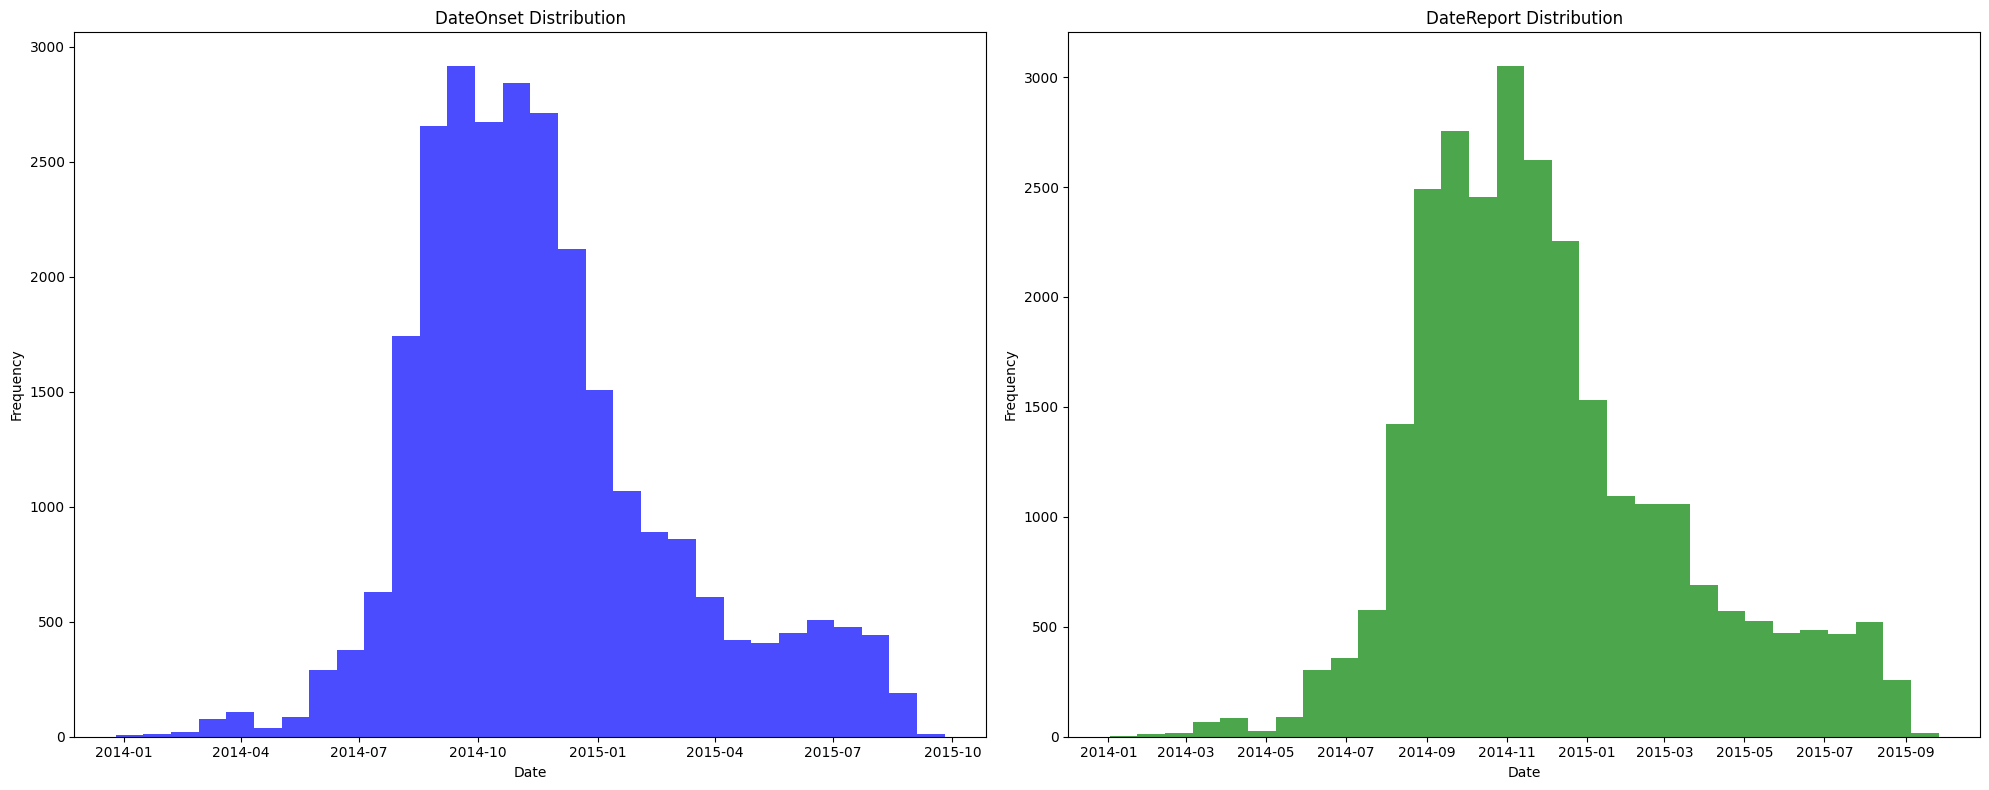

In [45]:
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.hist(ebola['DateOnset'].dropna(), bins=30, color='blue', alpha=0.7)
plt.title('DateOnset Distribution')
plt.xlabel('Date')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(ebola['DateReport'].dropna(), bins=30, color='green', alpha=0.7)
plt.title('DateReport Distribution')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig('./images/date_distribution.png', bbox_inches='tight')
plt.show()

### 2. Plot Case Definition

Text(0, 0.5, 'Number of Incidence')

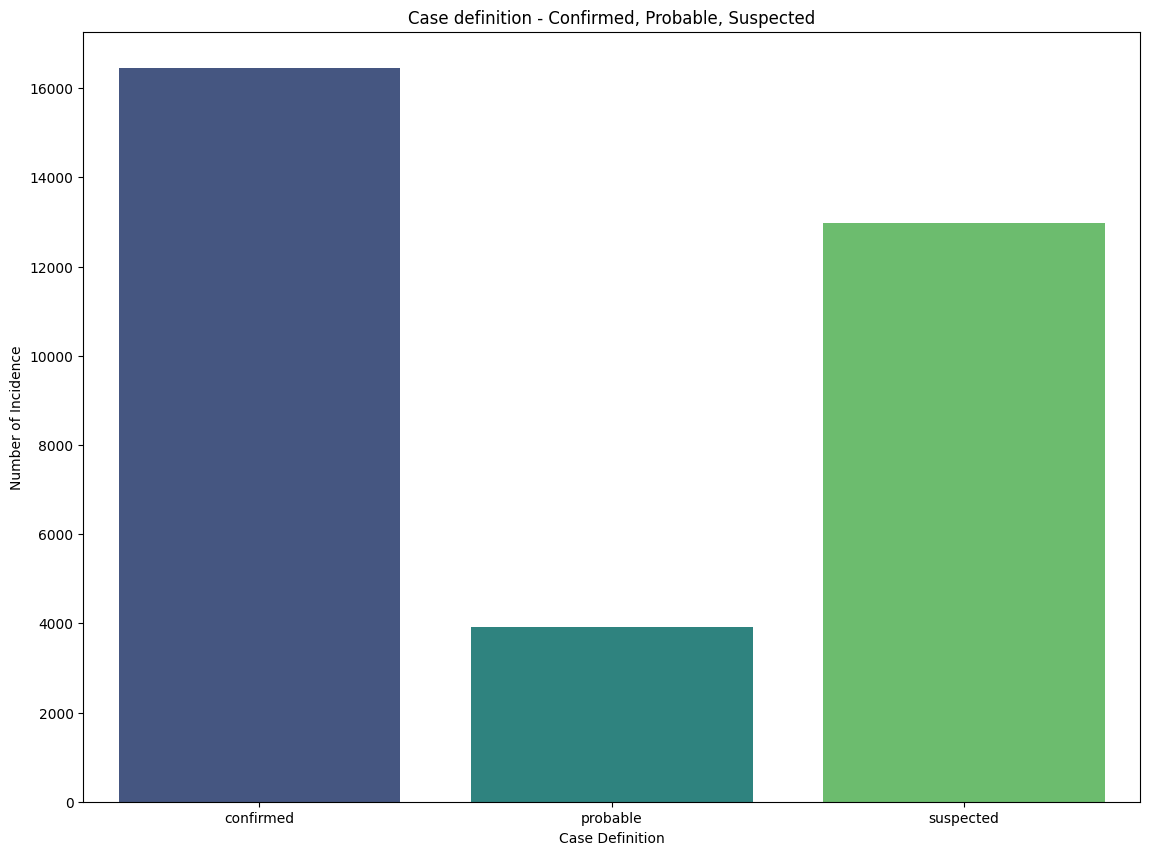

In [57]:
plt.figure(figsize=(30, 10))
plt.subplot(1, 2, 1)
sns.countplot(data = ebola, 
              x='EpiCaseDef',
              hue='EpiCaseDef',
              palette='viridis')
plt.title('Case definition - Confirmed, Probable, Suspected')
plt.xlabel('Case Definition')
plt.ylabel('Number of Incidence')

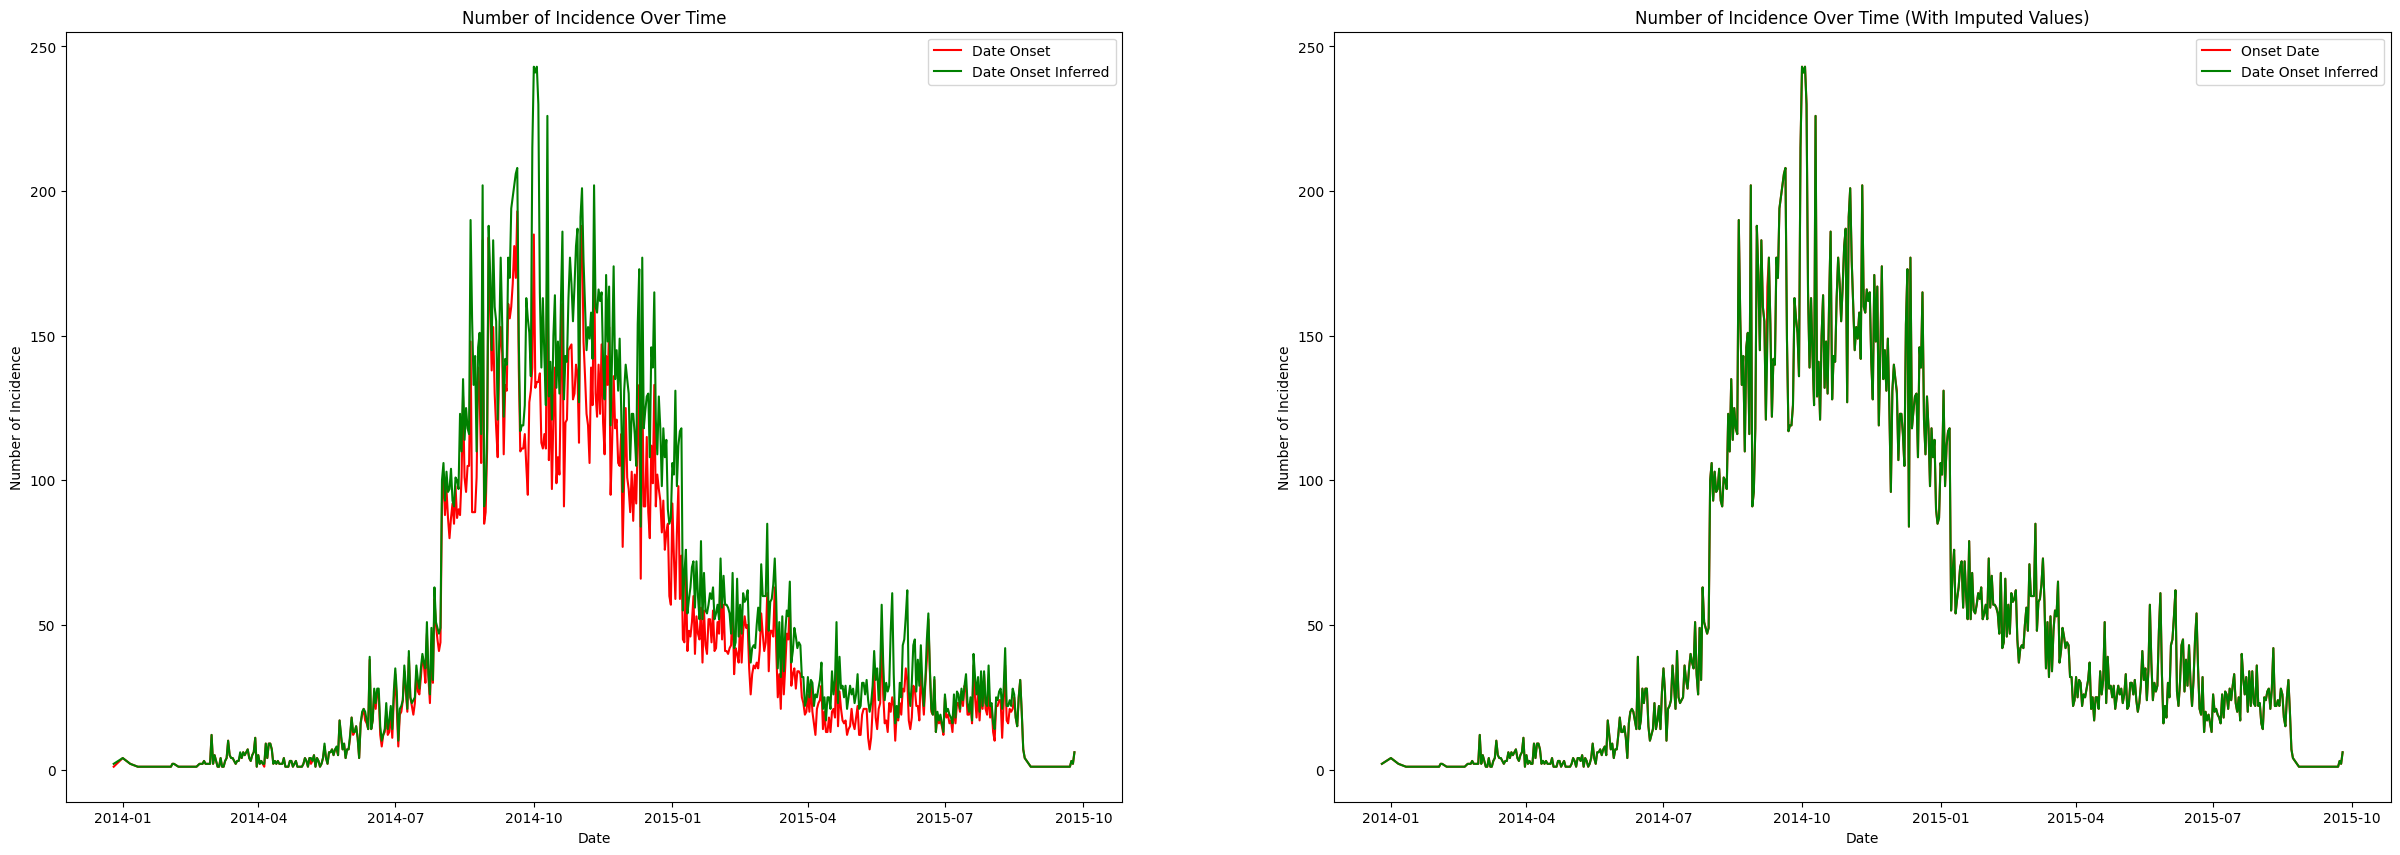

In [64]:
## plot the number of cases over time
plt.figure(figsize=(30, 10))
plt.subplot(1, 2, 1)
plt.plot(ebola['DateOnset'].value_counts().sort_index(), linestyle='-', color='red')
plt.plot(ebola['DateOnsetInferred'].value_counts().sort_index(), linestyle='-', color='green')
plt.title('Number of Incidence Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Incidence')
plt.legend(['Date Onset', 'Date Onset Inferred'])
# plt.xticks(rotation=45)
# plt.grid()
## save plot
# plt.savefig('./images/cases_over_time.png', bbox_inches='tight')
# plt.show()

plt.subplot(1, 2, 2)
plt.plot(ebola['OnsetDate'].value_counts().sort_index(), linestyle='-', color='red')
plt.plot(ebola['DateOnsetInferred'].value_counts().sort_index(), linestyle='-', color='green')
plt.title('Number of Incidence Over Time (With Imputed Values)')
plt.xlabel('Date')
plt.ylabel('Number of Incidence')
plt.legend(['Onset Date', 'Date Onset Inferred'])
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.grid()
## save plot
# plt.savefig('./images/cases_over_time.png', bbox_inches='tight')
plt.show()

### 3. Plot Daily cases

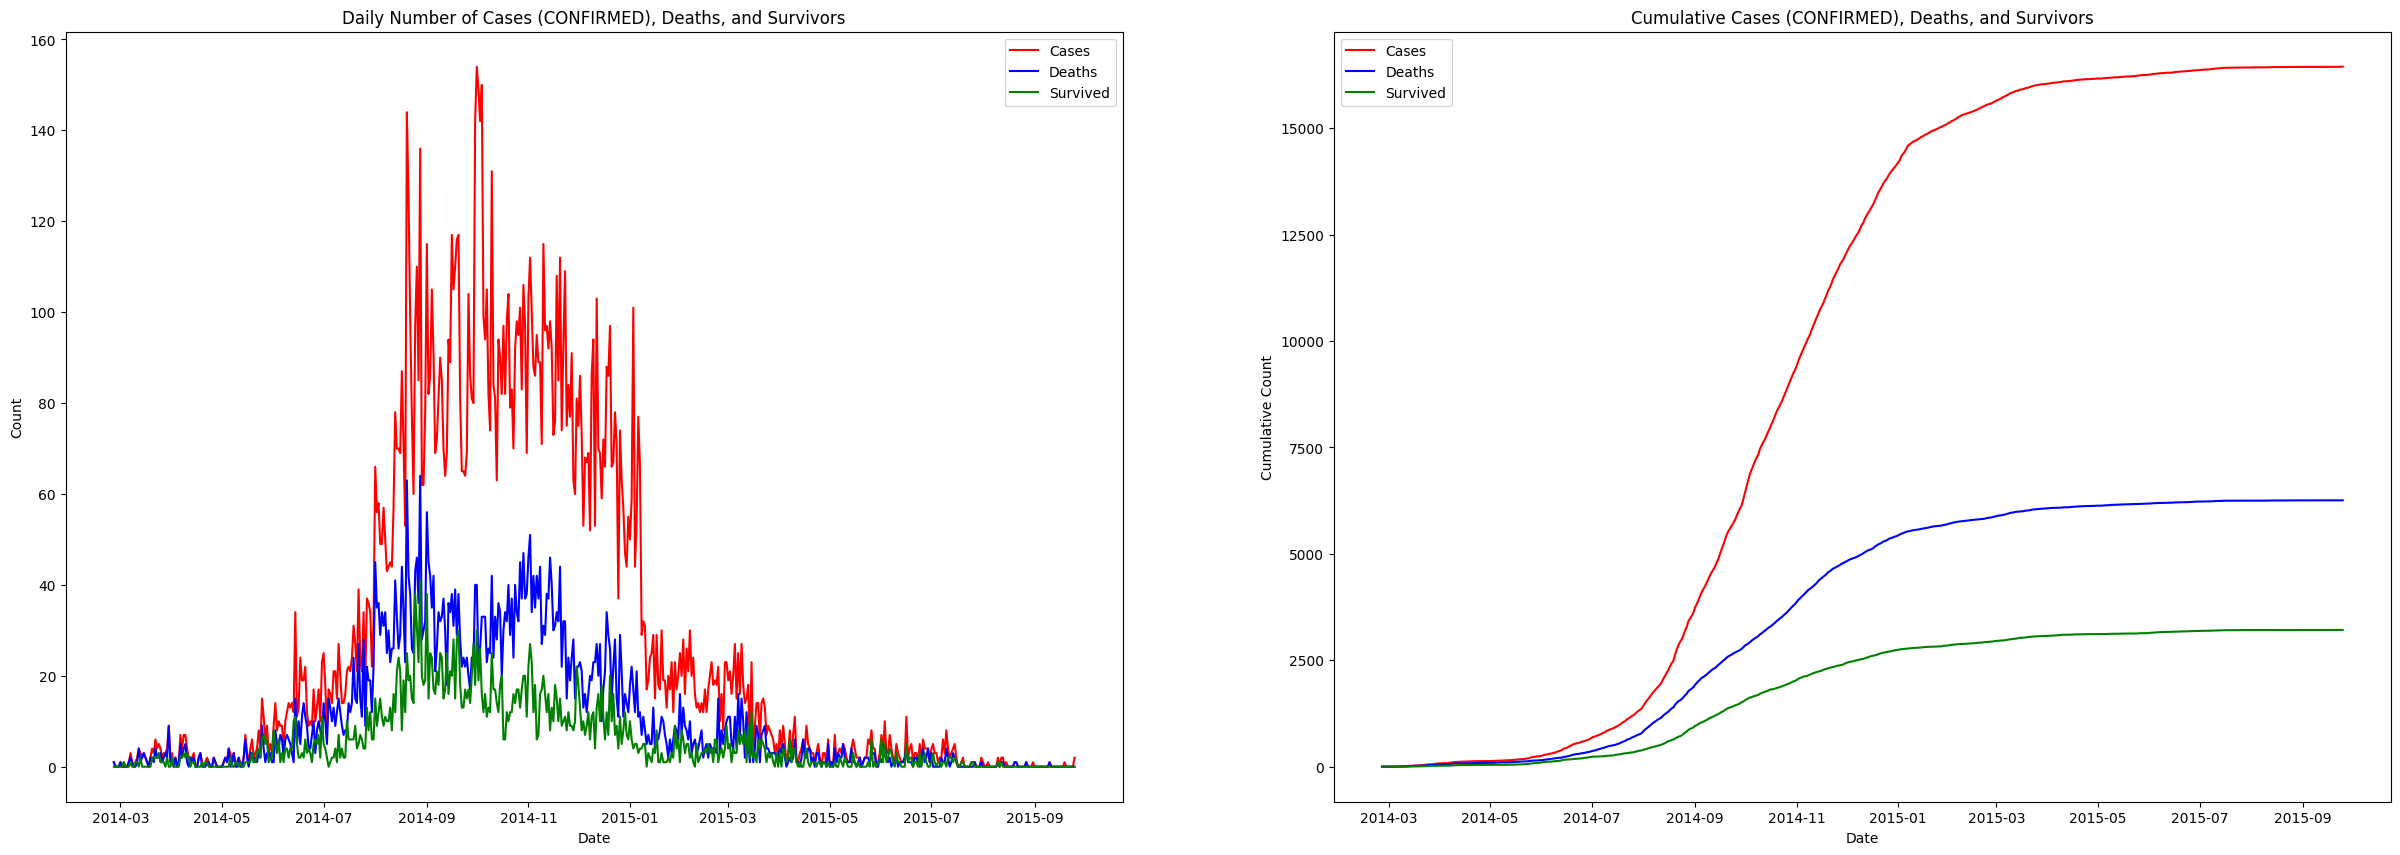

In [ ]:
plt.figure(figsize=(30, 10))
plt.subplot(1, 2, 1)
plt.plot(cases_by_day["DateOnset"], cases_by_day["Cases"], linestyle="-", color="red", label="Cases")
plt.plot(death_by_day["DateOnset"], death_by_day["FinalStatus"], linestyle="-", color="blue", label="Deaths")
plt.plot(survive_by_day["DateOnset"], survive_by_day["FinalStatus"], linestyle="-", color="green", label="Survived")
plt.title("Daily Number of Cases (CONFIRMED), Deaths, and Survivors")
plt.xlabel("Date")
plt.ylabel("Count")
plt.legend()
# plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(cases_by_day["DateOnset"], cases_by_day["CumulativeCases"], linestyle="-", color="red", label="Cases")
plt.plot(death_by_day["DateOnset"], death_by_day["CummulativeDeaths"], linestyle="-", color="blue", label="Deaths")
plt.plot(survive_by_day["DateOnset"], survive_by_day["CummulativeSurvival"], linestyle="-", color="green", label="Survived")
plt.title("Cumulative Cases (CONFIRMED), Deaths, and Survivors")
plt.xlabel("Date")
plt.ylabel("Cumulative Count")
plt.legend()
# plt.tight_layout()
# plt.grid(True)
plt.show()

### 4. Plot Incidence by country

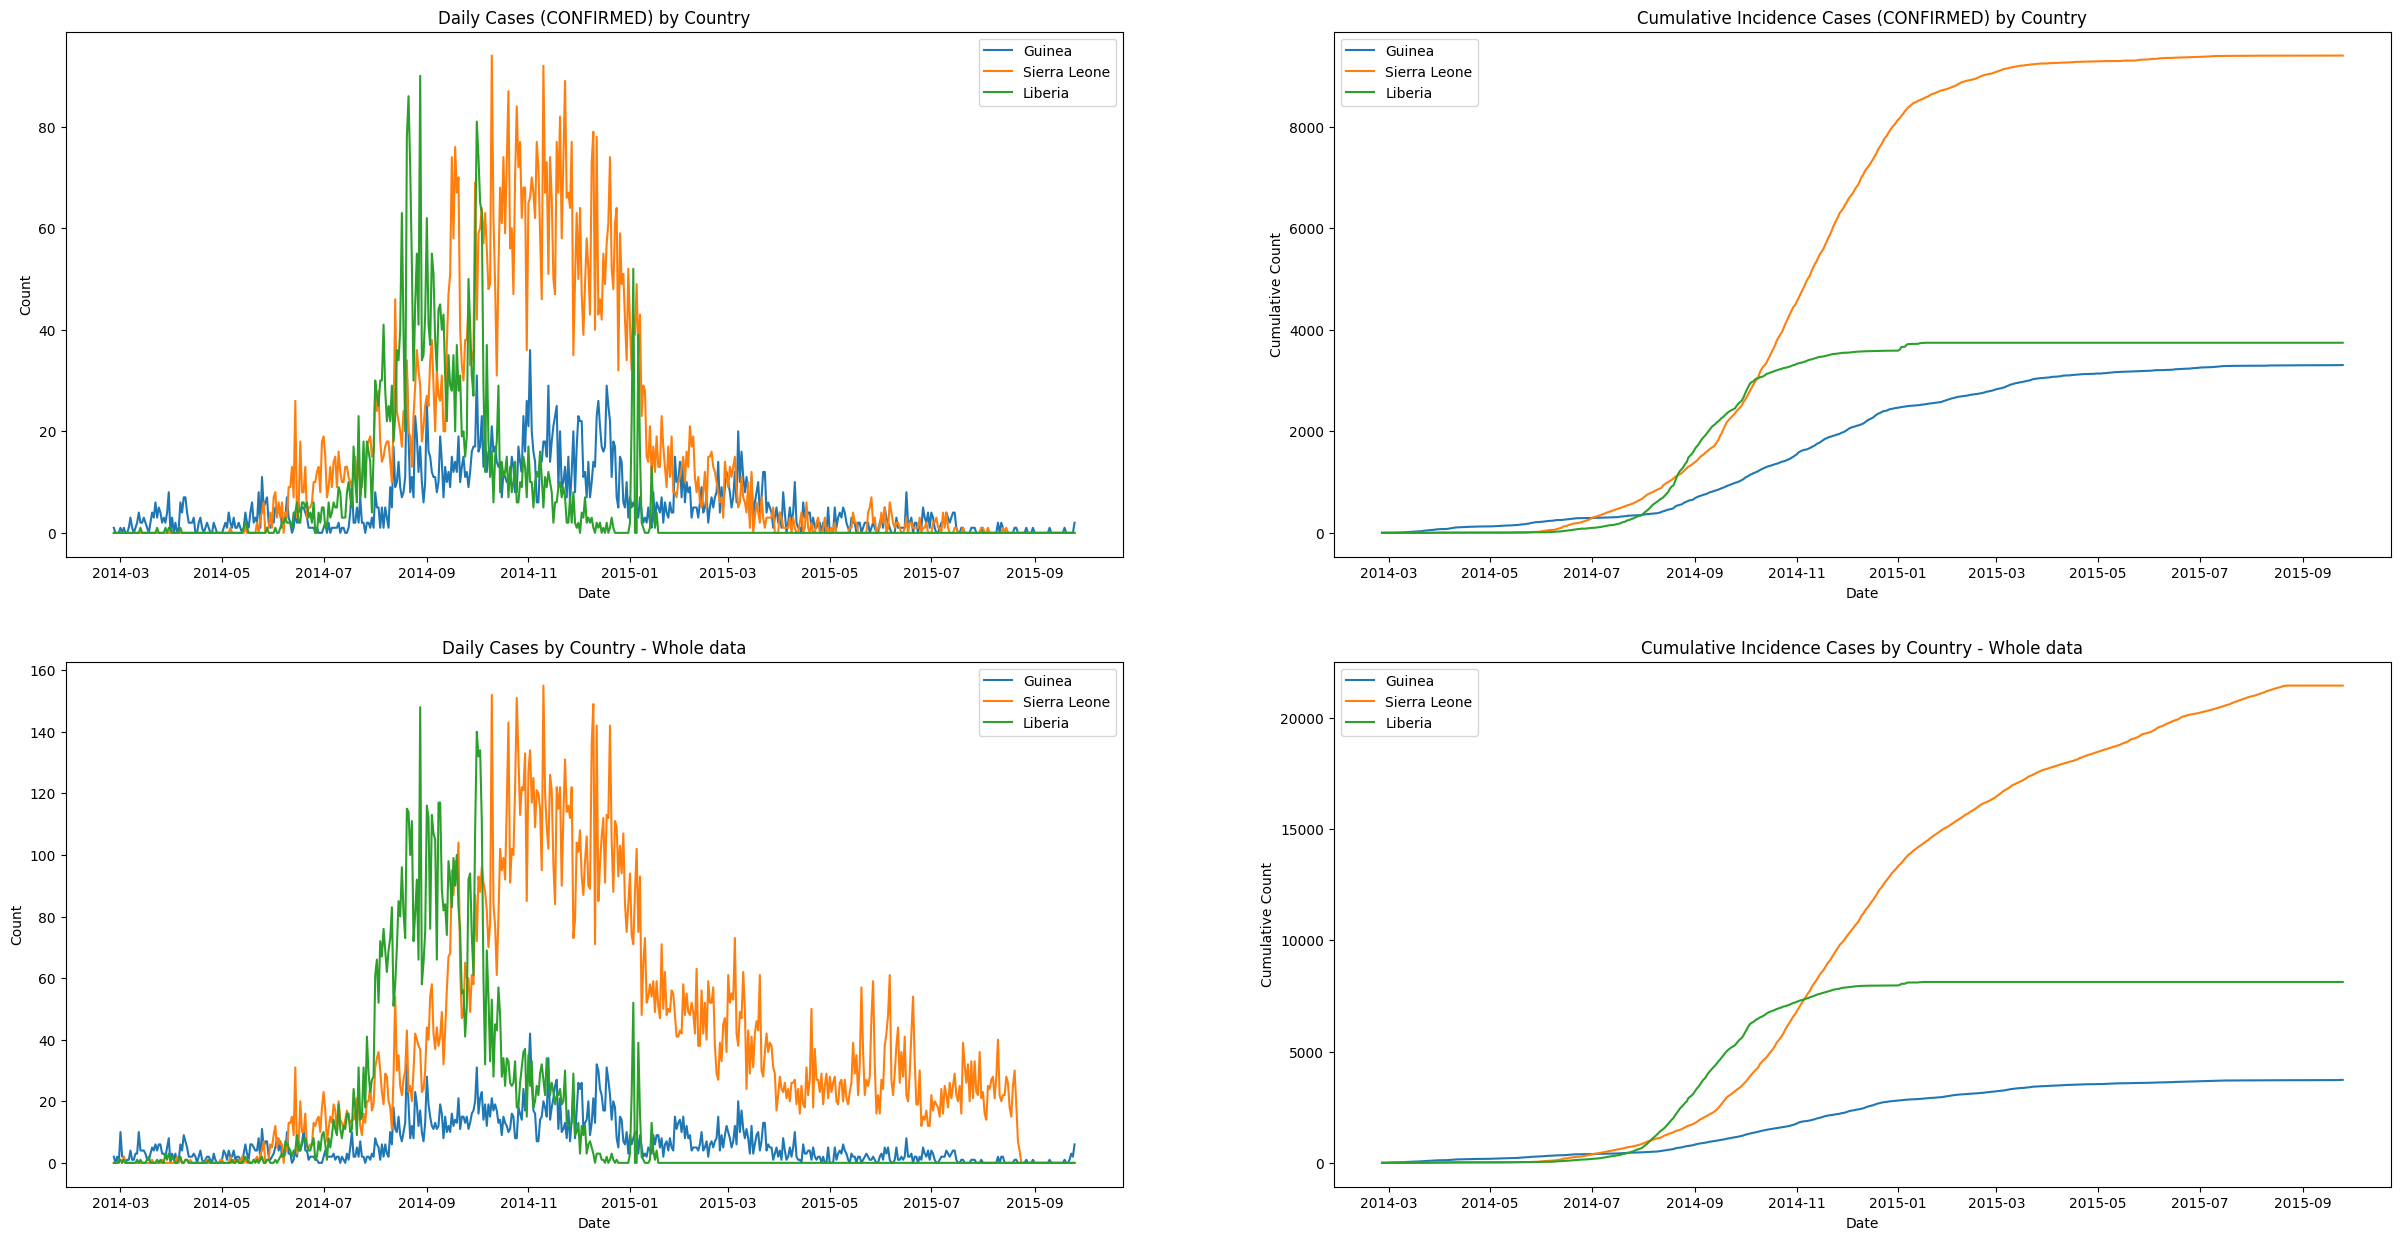

In [61]:
plt.figure(figsize=(30, 15))
plt.subplot(2, 2, 1)
for country in ebola_confirmed["Country"].unique():
    country_data = ebola_confirmed[ebola_confirmed["Country"] == country].groupby("OnsetDate").size().reset_index(name="Cases")
    country_data = country_data.set_index("OnsetDate").reindex(all_dates, fill_value=0).reset_index().rename(columns={"index": "DateOnset"})
    plt.plot(country_data["DateOnset"], country_data["Cases"], linestyle="-", label=country)
plt.title("Daily Cases (CONFIRMED) by Country")
plt.xlabel("Date")
plt.ylabel("Count")
plt.legend()
# plt.grid(True)

plt.subplot(2, 2, 2)
for country in ebola_confirmed["Country"].unique():
    country_data = ebola_confirmed[ebola_confirmed["Country"] == country].groupby("OnsetDate").size().reset_index(name="Cases")
    country_data = country_data.set_index("OnsetDate").reindex(all_dates, fill_value=0).reset_index().rename(columns={"index": "DateOnset"})
    country_data["CumulativeCases"] = country_data["Cases"].cumsum()
    plt.plot(country_data["DateOnset"], country_data["CumulativeCases"], linestyle="-", label=country)
plt.title("Cumulative Incidence Cases (CONFIRMED) by Country")
plt.xlabel("Date")
plt.ylabel("Cumulative Count")
plt.legend()
# plt.tight_layout()
# plt.grid()
# plt.savefig('./images/cases_by_country.png', bbox_inches='tight')


plt.subplot(2, 2, 3)
for country in ebola["Country"].unique():
    country_data = ebola[ebola["Country"] == country].groupby("OnsetDate").size().reset_index(name="Cases")
    country_data = country_data.set_index("OnsetDate").reindex(all_dates, fill_value=0).reset_index().rename(columns={"index": "DateOnset"})
    plt.plot(country_data["DateOnset"], country_data["Cases"], linestyle="-", label=country)
plt.title("Daily Cases by Country - Whole data")
plt.xlabel("Date")
plt.ylabel("Count")
plt.legend()
# plt.grid(True)

plt.subplot(2, 2, 4)
for country in ebola["Country"].unique():
    country_data = ebola[ebola["Country"] == country].groupby("OnsetDate").size().reset_index(name="Cases")
    country_data = country_data.set_index("OnsetDate").reindex(all_dates, fill_value=0).reset_index().rename(columns={"index": "DateOnset"})
    country_data["CumulativeCases"] = country_data["Cases"].cumsum()
    plt.plot(country_data["DateOnset"], country_data["CumulativeCases"], linestyle="-", label=country)
plt.title("Cumulative Incidence Cases by Country - Whole data")
plt.xlabel("Date")
plt.ylabel("Cumulative Count")
plt.legend()
# plt.tight_layout()
# plt.grid()
# plt.savefig('./images/cases_by_country.png', bbox_inches='tight')
plt.show()

### 5. Let's plot the Spatia Cases accross the countries

In [65]:
# Count cases by country
cases_by_country = ebola["CL_DistrictRes"].value_counts().reset_index()
cases_by_country.columns = ['Districts', 'cases']

# Merge with world data
world_with_cases = districts_filter.merge(cases_by_country, how='left', left_on='NAME_2', right_on='Districts')

In [66]:
world_with_cases['cases']=world_with_cases['cases'].fillna(0)
districts_filter['COUNTRY'].unique()

array(['Liberia', 'Guinea', 'Sierra Leone'], dtype=object)

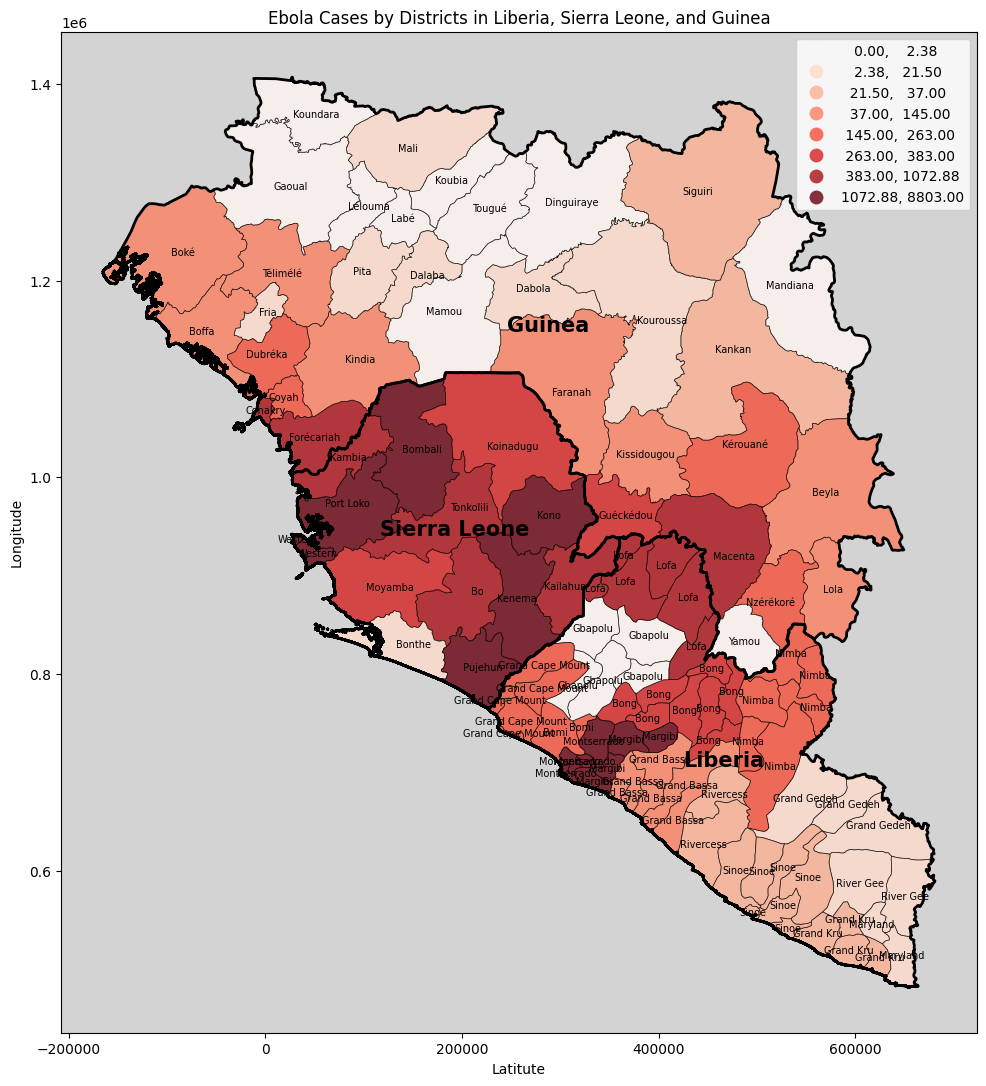

In [67]:
# Reproject to UTM Zone 29N (suitable for Liberia, Sierra Leone, Guinea)
world_with_cases = world_with_cases.to_crs(epsg=32629)

# Load country boundaries and filter for Liberia, Sierra Leone, and Guinea
countries = country_filter[country_filter['COUNTRY'].isin(['Liberia', 'Sierra Leone', 'Guinea'])]
countries = countries.to_crs(epsg=32629)  # Reproject to match world_with_cases

# Plot
fig, ax = plt.subplots(figsize=(30, 13))
ax.set_facecolor('lightgray')  # Add a light background

# Plot the choropleth map (regions)
world_with_cases.plot(
    column='cases', ax=ax, legend=True,
    missing_kwds={'color': 'lightgrey'},
    cmap='Reds', edgecolor='black',
    linewidth=0.5, alpha=0.8,
    scheme='quantiles', k=8
)

# Plot country boundaries with a thicker line
countries.boundary.plot(ax=ax, color='black', linewidth=2)

# Add country names at the centroids
for idx, row in countries.iterrows():
    centroid = row.geometry.centroid
    ax.text(centroid.x, centroid.y, row['COUNTRY'], fontsize=15, fontweight='bold', color='black', ha='center', va='center')

# Add region names using representative_point() to reduce overlap
for point, label in zip(world_with_cases.geometry.representative_point(),
                        world_with_cases['NAME_2']):
    ax.text(point.x, point.y, label, fontsize=7, ha='center', va='center')

# Update the title and remove axes labels
plt.title('Ebola Cases by Districts in Liberia, Sierra Leone, and Guinea')
ax.set_xlabel('Latitute')
ax.set_ylabel('Longitude')

# Save the plot
plt.savefig('./images/cases_by_district_map2.png', bbox_inches='tight')

plt.show()

# 4. Prepare the Data for Modelling

In [68]:
patch_names = ["Guinea", "Liberia", "Sierra Leone"]
n_patches = len(patch_names)
start_date = ebola_confirmed["OnsetDate"].min()
end_date = ebola_confirmed["OnsetDate"].max()
weeks = pd.date_range(start=start_date, end=end_date, freq="W-MON")
T = len(weeks) - 1

I_obs = np.zeros((T, n_patches))
for i, country in enumerate(patch_names):
    country_data = ebola_confirmed[ebola_confirmed["Country"] == country]
    weekly_cases = country_data.groupby(pd.Grouper(key="OnsetDate", freq="W-MON")).size()
    weekly_cases = weekly_cases.reindex(weeks[:-1], fill_value=0)
    I_obs[:, i] = weekly_cases.values

time = np.arange(1, T + 1)
data_plot = pd.DataFrame(I_obs, columns=patch_names)
data_plot["Time"] = time
data_plot = data_plot.melt(id_vars="Time", var_name="Patches", value_name="Cases")

In [259]:
weeks

DatetimeIndex(['2014-03-03', '2014-03-10', '2014-03-17', '2014-03-24',
               '2014-03-31', '2014-04-07', '2014-04-14', '2014-04-21',
               '2014-04-28', '2014-05-05', '2014-05-12', '2014-05-19',
               '2014-05-26', '2014-06-02', '2014-06-09', '2014-06-16',
               '2014-06-23', '2014-06-30', '2014-07-07', '2014-07-14',
               '2014-07-21', '2014-07-28', '2014-08-04', '2014-08-11',
               '2014-08-18', '2014-08-25', '2014-09-01', '2014-09-08',
               '2014-09-15', '2014-09-22', '2014-09-29', '2014-10-06',
               '2014-10-13', '2014-10-20', '2014-10-27', '2014-11-03',
               '2014-11-10', '2014-11-17', '2014-11-24', '2014-12-01',
               '2014-12-08', '2014-12-15', '2014-12-22', '2014-12-29',
               '2015-01-05', '2015-01-12', '2015-01-19', '2015-01-26',
               '2015-02-02', '2015-02-09', '2015-02-16', '2015-02-23',
               '2015-03-02', '2015-03-09', '2015-03-16', '2015-03-23',
      

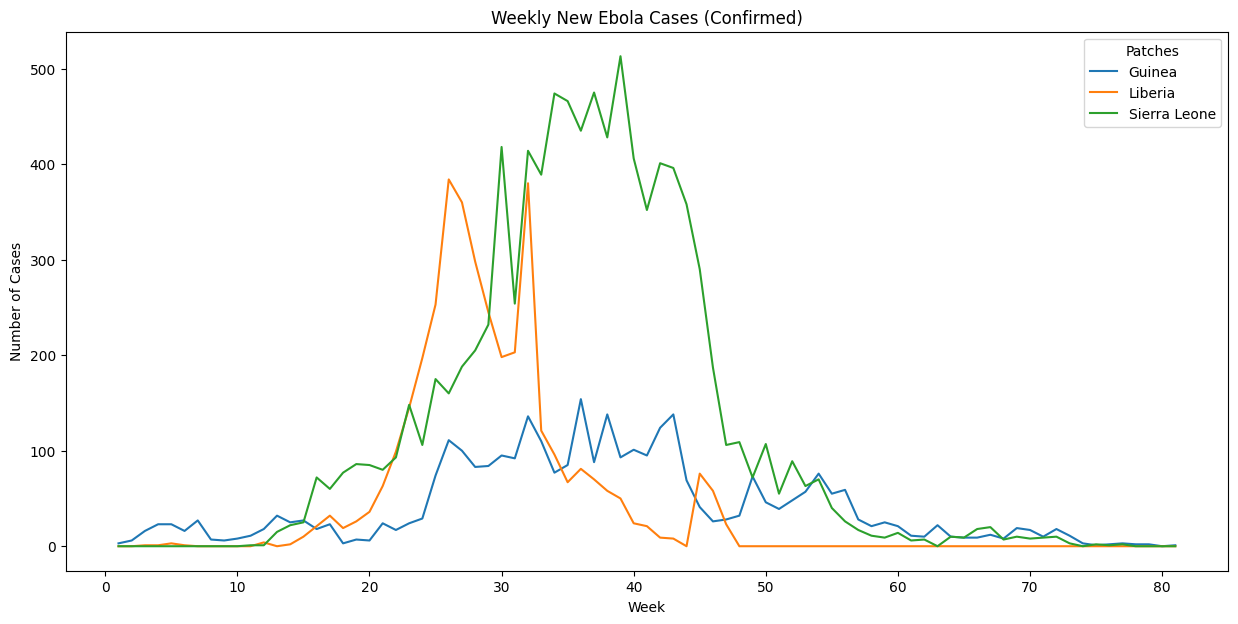

In [69]:
plt.figure(figsize=(15, 7))
sns.lineplot(data=data_plot, x="Time", y="Cases", hue="Patches")
plt.title("Weekly New Ebola Cases (Confirmed)")
plt.xlabel("Week")
plt.ylabel("Number of Cases")
# plt.grid(True)
plt.show()

# 4. Fitting a Simple SEIR model


## Simple SEIR Patch Model

With this simple model, each country Guinea, Liberia, and Sierra Leone will be treated as an independent patch, and we’ll fit a separate Susceptible(S), Exposed(E), Infectious(I), and Recovered(R) model to each country’s incidence data. The dynamics for each patch  $p$ (where $ p $ corresponds to the countries) is given below:

$$ \frac{dS_p}{dt} = -\beta_p S_p \frac{I_p}{N_p}$$

$$ \frac{dE_p}{dt} = \beta_p S_p \frac{I_p}{N_p} - \sigma E_p $$

$$\frac{dI_p}{dt} = \sigma E_p - \gamma I_p$$

$$\frac{dR_p}{dt} = \gamma I_p$$

Where:
- $ S_p, E_p, I_p, R_p $: Susceptible, Exposed, Infectious, and Recovered individuals in patch $ p $.
- $ N_p $: Total population for patch $ p $.
- $ \beta_p $: Transmission rate in patch $ p $.
- $ \sigma $: Rate of progression from Exposed to Infectious (inverse of the latent period).
- $ \gamma $: Recovery rate (inverse of the infectious period).

### New Infections
- The number of new infectious individuals in patch $ p $ at time $ t $ is given by the inflow into the Infectious compartment:
  $$
  \text{New Infectious}_p(t) = \sigma E_p(t)
  $$
- We’ll assume that the observed incidence data (`I_obs[t, p]`) corresponds to $ \sigma E_p $, since cases are typically reported when individuals become symptomatic (i.e., move from Exposed to Infectious).

### Observation Model
- We’ll use a Negative Binomial distribution to model the observed incidence data, accounting for overdispersion:
  $$
  I_{\text{obs}}[t, p] \sim \text{NegativeBinomial}(\sigma E_p(t), \phi)
  $$
  where $ \phi $ is the dispersion parameter.

### Initial Conditions and Parameters
- **Initial Conditions**:
  - At $ t = 0 $, assume $ S_p(0) \approx N_p $, $ E_p(0) = I_p(0) = 1 $, $ R_p(0) = 0 $ for each patch, since the outbreak started with a small number of exposed and infectious individuals.
  - $ N_p $: Population sizes for each country (approximate, from **Worldometer** 2014 estimates):
    - Guinea: 11.5 million
    - Liberia: 4.5 million
    - Sierra Leone: 6.8 million

- **Parameters to Estimate**:
  - $ \beta_p $: Transmission rate for each patch.
  - $ \phi $: Dispersion parameter for the Negative Binomial distribution.
  - $ E_{0,p} $, $ I_{0,p} $: Initial Exposed and Infectious individuals for each patch.

- **Fixed Parameters**:
  - $ \sigma $: Rate of progression from Exposed to Infectious (fixed at 1/5.3 days, based on Faye et al., 2015).
  - $ \gamma $: Recovery rate (fixed at 1/5 days, based on Faye et al., 2015).

### Discretization
Since the data is weekly, we’ll discretize the ODEs using a daily Euler method and aggregate the new infectious individuals into weekly counts to match `I_obs`.

In [ ]:
weekly_cases = data_plot.groupby("Time")["Cases"].sum()

# Ensure y has exactly T elements
y = weekly_cases.values[:T].astype(int) 

In [ ]:
ebola['DataOnset'].value_counts()

In [192]:
# Population sizes (approximate, in millions)
n = np.array([11.5e6, 4.5e6, 6.8e6])  # Guinea, Liberia, Sierra Leone

N = int(np.sum(n))
# Fixed parameters (based on literature)
sigma = 1.0 / 5.3  # Latent period: 5.3 days (Faye et al., 2015)
gamma = 1.0 / 5.0  # Infectious period: 5 days (Faye et al., 2015)

# Prepare data for Stan
stan_data = {
    "T": T,
    "t0": 0,
    # "n_patches": n_patches,
    "ts": time,
    "y": y,
    "N": N,
    "I0": 3
}

# Print data summary
print("Stan Data Summary:")
print(f"T: {stan_data['T']}")
# print(f"n_patches: {stan_data['n_patches']}")
print(f"N: {stan_data['N']}")
# print(f"E0: {stan_data['E0']}")
print(f"I0: {stan_data['I0']}")

Stan Data Summary:
T: 81
N: 22800000
I0: 3


In [258]:
# Compile and fit the model
model = CmdStanModel(stan_file="seir_model.stan")
fit = model.sample(
    data=stan_data,
    chains=4,
    parallel_chains=4,
    iter_warmup=500,
    iter_sampling=1000,
    seed=123
)

# Convert to ArviZ InferenceData for analysis
inference_data = az.from_cmdstanpy(fit)

21:56:24 - cmdstanpy - INFO - compiling stan file /media/brasammy/5B6DAD9B6A1F7E40/Projects/Thesis/Main/thesis/seir_model.stan to exe file /media/brasammy/5B6DAD9B6A1F7E40/Projects/Thesis/Main/thesis/seir_model
INFO:cmdstanpy:compiling stan file /media/brasammy/5B6DAD9B6A1F7E40/Projects/Thesis/Main/thesis/seir_model.stan to exe file /media/brasammy/5B6DAD9B6A1F7E40/Projects/Thesis/Main/thesis/seir_model
21:56:35 - cmdstanpy - INFO - compiled model executable: /media/brasammy/5B6DAD9B6A1F7E40/Projects/Thesis/Main/thesis/seir_model
INFO:cmdstanpy:compiled model executable: /media/brasammy/5B6DAD9B6A1F7E40/Projects/Thesis/Main/thesis/seir_model
21:56:35 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |█▏        | 00:37 Iteration:    1 / 1500 [  0%]  (Warmup)





chain 1 |█▊        | 00:46 Iteration:  100 / 1500 [  6%]  (Warmup)


chain 1 |██▎       | 00:49 Iteration:  200 / 1500 [ 13%]  (Warmup)

chain 1 |


22:04:15 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
22:04:15 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: poisson_lpmf: Rate parameter is -5.01806e-08, but must be nonnegative! (in 'seir_model.stan', line 65, column 4 to column 36)
	Exception: ode_rk45: ode parameters and data[3] is inf, but must be finite! (in 'seir_model.stan', line 60, column 2 to column 73)
	Exception: ode_rk45: ode parameters and data[3] is inf, but must be finite! (in 'seir_model.stan', line 60, column 2 to column 73)
	Exception: ode_rk45: ode parameters and data[3] is inf, but must be finite! (in 'seir_model.stan', line 60, column 2 to column 73)
	Exception: ode_rk45: ode parameters and data[3] is inf, but must be finite! (in 'seir_model.stan', line 60, column 2 to column 73)
	Exception: ode_rk45: ode parameters and data[3] is inf, but must be finite! (in 'seir_model.stan', line 60, column 2 to column 73)
	Exception: ode_rk45: ode parameters and 

In [ ]:
# Summary of parameter estimates
summary = az.summary(inference_data, var_names=["beta", "sigma", "gamma", "R0", "y_pred", "predicted_cases"])
print(summary)

# Extract posterior samples
posterior = fit.draws_pd(vars=["beta", "sigma", "gamma", "R0", "predicted_cases"])

                        mean      sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
beta                   0.071   0.001    0.070    0.073      0.000    0.000   
sigma                  1.152   0.033    1.084    1.208      0.001    0.001   
gamma                  0.003   0.001    0.002    0.004      0.000    0.000   
R0                    26.393   5.759   16.733   37.012      0.152    0.178   
predicted_cases[0]     3.064   1.707    0.000    6.000      0.039    0.029   
...                      ...     ...      ...      ...        ...      ...   
predicted_cases[76]  417.094  21.098  374.000  453.000      0.475    0.323   
predicted_cases[77]  445.322  21.923  403.000  483.000      0.500    0.339   
predicted_cases[78]  475.074  21.951  434.000  516.000      0.515    0.323   
predicted_cases[79]  506.916  23.989  457.000  547.000      0.528    0.375   
predicted_cases[80]  540.282  24.092  493.000  582.000      0.540    0.378   

                     ess_bulk  ess_tail  r_hat  
beta          

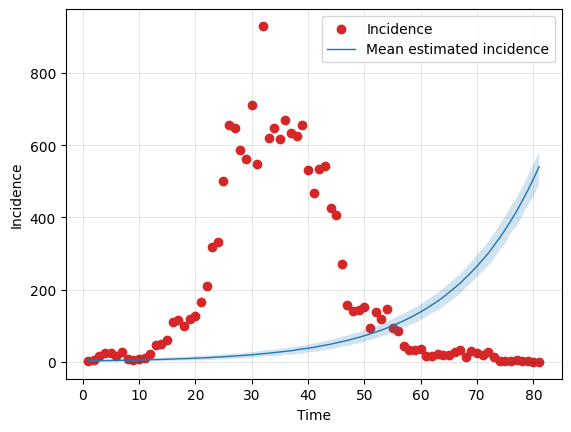

In [256]:


post_pred = pd.DataFrame(summary.filter(like="predicted_cases", axis=0))
post_pred["t"] = range(1, 82)
post_pred["incidence"] = list(y)

post_pred = post_pred.set_index("t")

fig, ax1 = plt.subplots()
ax1.grid(True, which='both', color = 'k', alpha = 0.1)
ax1.set_ylabel('Incidence')
ax1.set_xlabel('Time')
ax1.scatter(x = post_pred.index, y = post_pred['incidence'], color = 'tab:red', label = "Incidence")
ax1.plot(post_pred.index, post_pred['mean'], color = 'tab:blue', linewidth= 1, label = "Mean estimated incidence")
ax1.fill_between(x = post_pred.index,  y1 = post_pred['hdi_3%'], y2 = post_pred['hdi_97%'], alpha=0.2)
ax1.set_facecolor('white')
ax1.legend(loc = "upper right")

In [249]:
post_pred

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,incidence
t,,,,,,,,,,
1,3.064,1.707,0.0,6.0,0.039,0.029,1963.0,2073.0,1.0,3
2,3.228,1.828,0.0,6.0,0.041,0.032,1923.0,1980.0,1.0,6
3,3.450,1.860,0.0,6.0,0.041,0.032,2025.0,1963.0,1.0,17
4,3.677,1.900,1.0,7.0,0.043,0.034,1952.0,1900.0,1.0,24
5,4.012,1.985,0.0,7.0,0.047,0.033,1830.0,1811.0,1.0,26
...,...,...,...,...,...,...,...,...,...,...
77,417.094,21.098,374.0,453.0,0.475,0.323,1975.0,1829.0,1.0,5
78,445.322,21.923,403.0,483.0,0.500,0.339,1919.0,1825.0,1.0,2
79,475.074,21.951,434.0,516.0,0.515,0.323,1818.0,1948.0,1.0,2


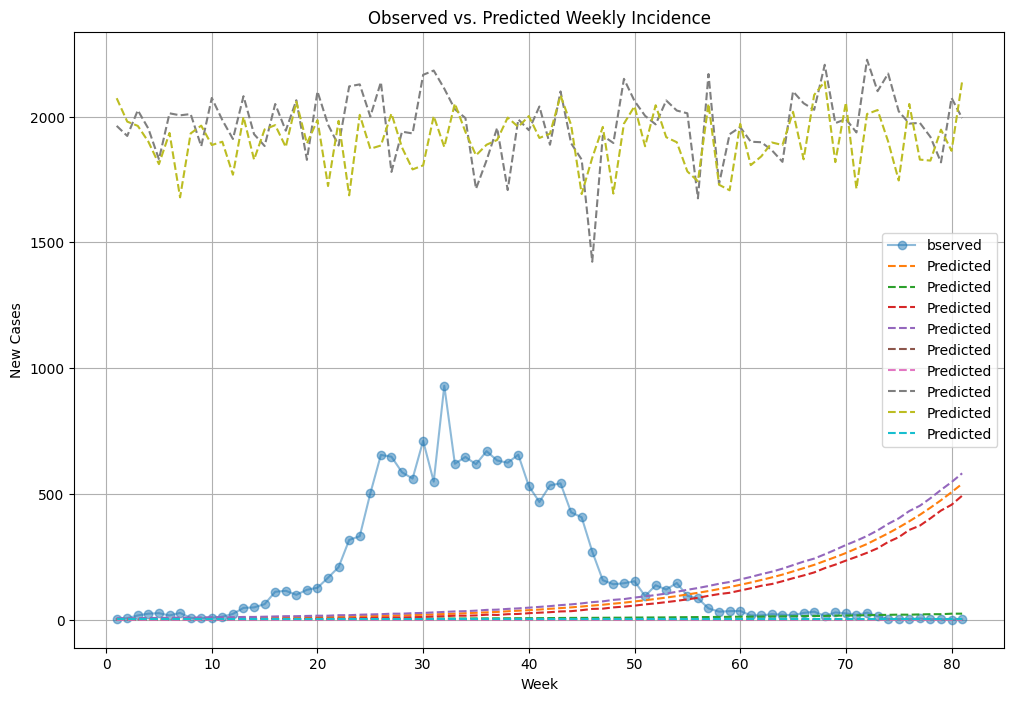

In [ ]:
# Plot observed vs. predicted incidence
# I_pred_mean = posterior[[f"predicted_cases.{t+1}.{p+1}" for t in range(T) for p in range(n_patches)]].mean()
# I_pred_mean = I_pred_mean.values.reshape(T, n_patches)

plt.figure(figsize=(12, 8))
for p in range(1):
    plt.plot(time, y, label=f"observed", linestyle="-", marker="o", alpha=0.5)
    plt.plot(time, ynew, label=f"Predicted", linestyle="--")
plt.title("Observed vs. Predicted Weekly Incidence")
plt.xlabel("Week")
plt.ylabel("New Cases")
plt.legend()
plt.grid(True)
plt.show()

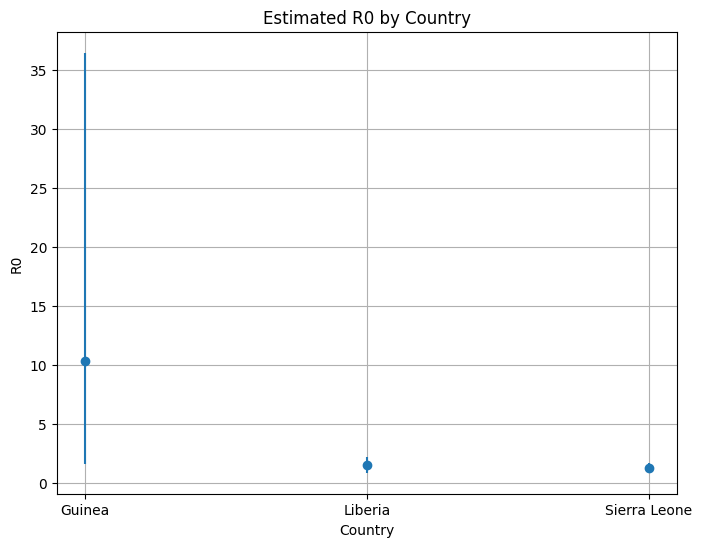

In [79]:
# Plot R0 for each patch
R0_mean = posterior[[f"R0[{p+1}]" for p in range(n_patches)]].mean()
R0_hdi = az.hdi(inference_data, var_names=["R0"])["R0"].values

plt.figure(figsize=(8, 6))
plt.errorbar(range(n_patches), R0_mean, yerr=(R0_mean - R0_hdi[:, 0], R0_hdi[:, 1] - R0_mean), fmt="o")
plt.xticks(range(n_patches), patch_names)
plt.title("Estimated R0 by Country")
plt.xlabel("Country")
plt.ylabel("R0")
plt.grid(True)
plt.show()